# Introduction

In this project, you will build a neural network of your own design to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


MNIST is a great dataset for sanity checking your models, since the accuracy levels achieved by large convolutional neural networks and small linear models are both quite high. This makes it important to be familiar with the data.

## Installation

In [1]:
# Restart the Kernel after you execute this command.

!python -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 139 kB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 216 kB 34.6 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 76.1 MB/s eta 0:00:01


**Important: Restart the Kernel at this moment**

## Imports

In [1]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list if you intend to .
The transforms module is already loaded as `transforms`.

MNIST is fortunately included in the torchvision module.
Then, you can create your dataset using the `MNIST` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/datasets.html#mnist)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create training set and define training dataloader
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

# Create test set and define test dataloader
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Justify your preprocessing

In your own words, why did you choose the transforms you chose? If you didn't use any preprocessing steps, why not?

I chose those transforms because MNIST images are simple grayscale digits, so the main preprocessing goals are:

1. Convert images to tensors

Models in PyTorch require tensor inputs, and transforms.ToTensor() also scales pixel values from the original [0, 255] range down to [0.0, 1.0].

2. Normalize the data

I normalized using transforms.Normalize((0.5,), (0.5,)) so that pixel values are roughly centered around 0 with a range close to [-1, 1].

Centering the data helps the optimizer converge faster and more reliably, especially with gradient-based methods like SGD or Adam.

I didn’t include complex preprocessing like rotations, flips, or color jitter because MNIST digits are already clean, centered, and consistent. Extra augmentation might slightly improve generalization, but for the baseline model, these two steps are enough to get good accuracy without introducing noise or distortions.

## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [3]:
## This cell contains a function for showing 5 images from a dataloader – DO NOT CHANGE THE CONTENTS! ##
def show5(img_loader):
    dataiter = iter(img_loader)
    
    batch = next(dataiter)
    labels = batch[1][0:5]
    images = batch[0][0:5]
    for i in range(5):
        print(int(labels[i].detach()))
    
        image = images[i].numpy()
        plt.imshow(image.T.squeeze().T)
        plt.show()

Images shape: torch.Size([64, 1, 28, 28])
Labels shape: torch.Size([64])
First 5 labels: [9 1 0 6 3]
5


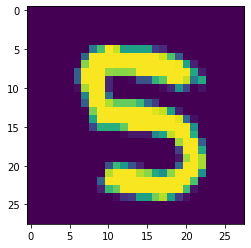

2


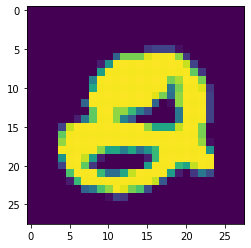

6


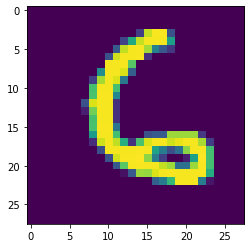

0


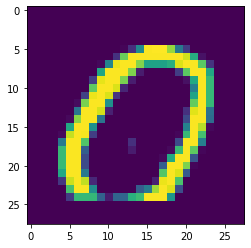

0


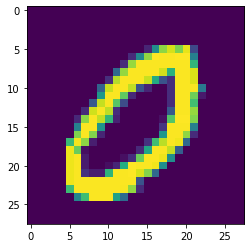

In [4]:
# Explore data


# Explore dimensions of one batch from training data
dataiter = iter(trainloader)  # trainloader is the DataLoader for training data
images, labels = next(dataiter)

print("Images shape:", images.shape)  # Expected: [batch_size, channels, height, width]
print("Labels shape:", labels.shape)
print("First 5 labels:", labels[:5].numpy())

# Show 5 sample images from training data
show5(trainloader)


## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset.
Use any architecture you like. 

*Note*: If you did not flatten your tensors in your transforms or as part of your preprocessing and you are using only `Linear` layers, make sure to use the `Flatten` layer in your network!

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class MNISTClassifier(nn.Module):
    def __init__(self):
        super(MNISTClassifier, self).__init__()
        
        # Flatten will turn [batch_size, 1, 28, 28] → [batch_size, 784]
        self.flatten = nn.Flatten()
        
        # Fully connected layers
        self.fc1 = nn.Linear(28*28, 128)  # input → hidden
        self.fc2 = nn.Linear(128, 64)     # hidden → hidden
        self.fc3 = nn.Linear(64, 10)      # hidden → output (10 classes)
        
        # Optional dropout for regularization
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # raw logits
        return x

# Create an instance of the network
model = MNISTClassifier()
print(model)


MNISTClassifier(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [6]:
import torch.optim as optim

# Instantiate the model
model = MNISTClassifier()

# Loss function: CrossEntropyLoss is standard for multi-class classification
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam is a good general-purpose optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)


nn.CrossEntropyLoss():
Works directly with raw logits from the model’s final layer, combining LogSoftmax and NLLLoss in one step.
This is the standard choice for multi-class classification problems like MNIST.

Adam optimizer:
Adaptive learning rate and momentum make it well-suited for a wide range of problems without much tuning.

## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss **during** each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [9]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 5
print_every = 250  # Print loss every 250 batches

for epoch in range(epochs):
    running_loss = 0.0
    model.train()  # Set model to training mode

    for batch_i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass & optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch_i + 1) % print_every == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_i+1}], Loss: {loss.item():.4f}")

    avg_loss = running_loss / len(trainloader)
    print(f"Epoch [{epoch+1}/{epochs}] Average Loss: {avg_loss:.4f}")

print("Training complete!")


Epoch [1/5], Batch [250], Loss: 0.3067
Epoch [1/5], Batch [500], Loss: 0.1729
Epoch [1/5], Batch [750], Loss: 0.2782
Epoch [1/5] Average Loss: 0.2611
Epoch [2/5], Batch [250], Loss: 0.3278
Epoch [2/5], Batch [500], Loss: 0.0640
Epoch [2/5], Batch [750], Loss: 0.1439
Epoch [2/5] Average Loss: 0.2145
Epoch [3/5], Batch [250], Loss: 0.1796
Epoch [3/5], Batch [500], Loss: 0.2833
Epoch [3/5], Batch [750], Loss: 0.1551
Epoch [3/5] Average Loss: 0.1926
Epoch [4/5], Batch [250], Loss: 0.1129
Epoch [4/5], Batch [500], Loss: 0.0912
Epoch [4/5], Batch [750], Loss: 0.0921
Epoch [4/5] Average Loss: 0.1740
Epoch [5/5], Batch [250], Loss: 0.2385
Epoch [5/5], Batch [500], Loss: 0.1221
Epoch [5/5], Batch [750], Loss: 0.1843
Epoch [5/5] Average Loss: 0.1633
Training complete!


Plot the training loss (and validation loss/accuracy, if recorded).

Epoch [1/5] - Train Loss: 0.1512 | Val Loss: 0.0994 | Val Acc: 0.9695
Epoch [2/5] - Train Loss: 0.1430 | Val Loss: 0.0944 | Val Acc: 0.9711
Epoch [3/5] - Train Loss: 0.1353 | Val Loss: 0.0950 | Val Acc: 0.9715
Epoch [4/5] - Train Loss: 0.1329 | Val Loss: 0.0918 | Val Acc: 0.9718
Epoch [5/5] - Train Loss: 0.1305 | Val Loss: 0.0973 | Val Acc: 0.9701


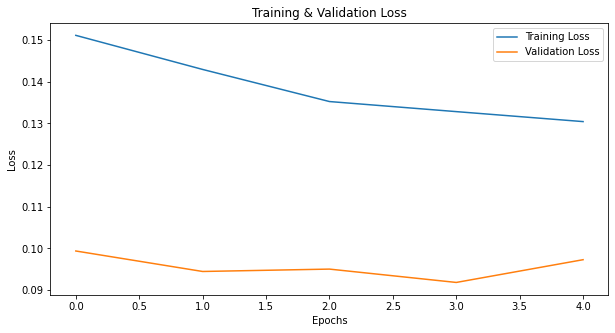

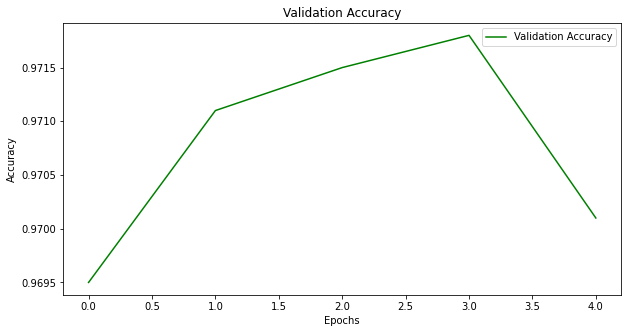

In [11]:
# Lists to store metrics
train_losses = []
val_losses = []
val_accuracies = []

epochs = 5
print_every = 250

for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for batch_i, (images, labels) in enumerate(trainloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Record training loss
    avg_train_loss = running_loss / len(trainloader)
    train_losses.append(avg_train_loss)

    # Validation step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(testloader)
    val_losses.append(avg_val_loss)

    accuracy = correct / total
    val_accuracies.append(accuracy)

    print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {accuracy:.4f}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

# Plot validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(val_accuracies, label="Validation Accuracy", color="green")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.show()


## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 90%, great work, but see if you can push a bit further! 
If your accuracy is under 90%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [12]:
# Evaluate accuracy on test set
correct = 0
total = 0

model.eval()  # Set to evaluation mode

with torch.no_grad():  # No gradients needed for evaluation
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # Pick class with highest probability

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 97.01%


## Improving your model

Once your model is done training, try tweaking your hyperparameters and training again below to improve your accuracy on the test set!

In [13]:
# Tuning hyperparameters for better performance

# 1. Define a new model architecture
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 512),  # Larger hidden layer
    nn.ReLU(),
    nn.Dropout(0.3),        # Prevent overfitting
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(256, 10)
).to(device)

# 2. Loss function
criterion = nn.CrossEntropyLoss()

# 3. Optimizer (lower LR, more epochs)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

# 4. Train again with tuned parameters
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Evaluate on test set after each epoch
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(trainloader):.4f}, Test Accuracy: {accuracy:.2f}%")


Epoch [1/10], Loss: 0.3862, Test Accuracy: 94.50%
Epoch [2/10], Loss: 0.2020, Test Accuracy: 96.23%
Epoch [3/10], Loss: 0.1633, Test Accuracy: 96.86%
Epoch [4/10], Loss: 0.1410, Test Accuracy: 97.00%
Epoch [5/10], Loss: 0.1310, Test Accuracy: 97.44%
Epoch [6/10], Loss: 0.1187, Test Accuracy: 97.50%
Epoch [7/10], Loss: 0.1136, Test Accuracy: 97.38%
Epoch [8/10], Loss: 0.1062, Test Accuracy: 97.42%
Epoch [9/10], Loss: 0.0997, Test Accuracy: 97.57%
Epoch [10/10], Loss: 0.0943, Test Accuracy: 97.78%


Increased hidden layer size for more learning capacity.

Added Dropout to reduce overfitting.

Reduced learning rate for more stable convergence.

Increased epochs to give the model more time to learn.

add data augmentation (random rotations, shifts, flips) is for further improve generalization (not applied)

## Saving your model
Using `torch.save`, save your model for future loading.

In [14]:
# Save the trained model
model_path = "mnist_model.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


Model saved to mnist_model.pth


 in practice, saving with state_dict() is preferred because it’s more portable and avoids dependency issues when loading later.
 torch.save(model, "mnist_model_full.pth")
 wıth torch.load() can reload and use the model later.
